## Nanophotonic natural language processing

In [1]:
width, depth = 4, 2  # width and depth of the piece of chip for one word

n_photons = 2
input_modes = output_modes = [0, 1, 1, 0]

bias, weight = -0.7, 5  # bias and weight for the classical post-processing

n_iter, alpha, gamma = 100, 0.602, 0.101  # optimization, hyper-parameters

SEED = 420

In [2]:
E = [x if not i else x + str(i + 1) 
     for i in range(1) for x in ["Alice", "Bob", "Claire", "Dave", "Eve", "Fred"]]
R = ["loves", "kills", "hates"]

print("Nouns: {}".format(', '.join(E)))
print("Verbs: {}".format(', '.join(R)))

Nouns: Alice, Bob, Claire, Dave, Eve, Fred
Verbs: loves, kills, hates


108 subject-verb-object sentences:


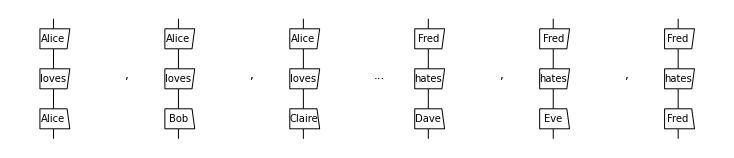

In [3]:
from discopy import Ty, Word, drawing

n = Ty('n')

class SimpleWord(Word):
    """ Word boxes with `dom == cod == n`. """
    def __init__(self, name, dom=n, cod=n, data=None, _dagger=False):
        super().__init__(name, dom=dom, cod=cod, data=data, _dagger=_dagger)

corpus = {
    ' '.join([x, r, y]):
    SimpleWord(x) >> SimpleWord(r) >> SimpleWord(y).dagger()
    for x in E for r in R for y in E}

print("{} subject-verb-object sentences:".format(len(corpus)))
start = drawing.Equation(*list(corpus.values())[:3], symbol=',')
end = drawing.Equation(*list(corpus.values())[-3:], symbol=',')
drawing.equation(start, end, symbol='...', asymmetry=5e-2, figsize=(10, 2), draw_type_labels=False)

In [4]:
import numpy as np; np.random.seed(SEED)

from discopy.quantum.optics_vienna import Id, MZI
from discopy.quantum.optics_vienna import Functor

def ansatz(params):
    depth, half_width, _ = params.shape
    chip = Id(2 * half_width)
    for i in range(depth):
        chip >>= Id().tensor(*[
                MZI(*params[i, j]) for j in range(half_width)])\
            if not i % 2 else Id(1).tensor(*[
                MZI(*params[i, j]) for j in range(half_width - 1)]) @ Id(1)
    return chip

Ansatz for 'Bob' (6 parameters):


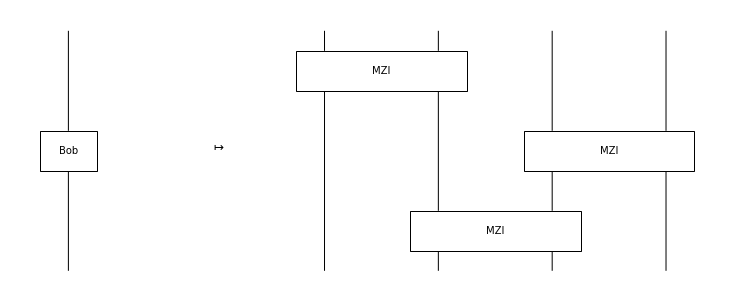

Total: 9 * 6 = 54 parameters.
[0.31564591 0.45303068 0.26698226 ... 0.25445189 0.35811394 0.50401754]


In [5]:
n_params = 2 * (depth * width // 2 - depth // 2)

random_params = lambda: np.random.uniform(size=(len(E + R), depth, width // 2, 2))

params0 = random_params()

print("Ansatz for 'Bob' ({} parameters):".format(n_params))

drawing.equation(
    SimpleWord('Bob'), ansatz(params0[1]),
    draw_type_labels=False, symbol='$\\mapsto$', figsize=(10, 4))

print("Total: {} * {} = {} parameters.".format(len(E + R), n_params, len(E + R) * n_params))
print(params0.flatten())

Ansatz for 'Alice loves Bob':


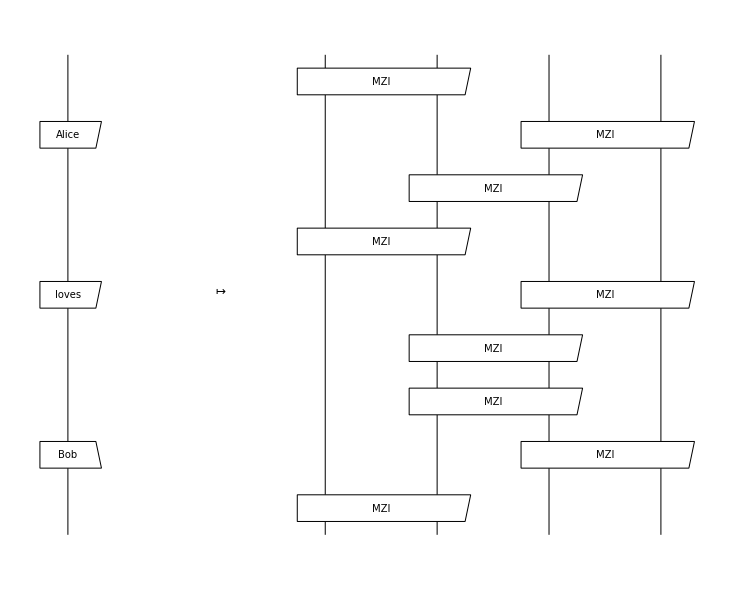

In [6]:
F = lambda params: Functor(
    ob={n: Ty(1) ** width},
    ar={SimpleWord(w): ansatz(params[i]) for i, w in enumerate(E + R)})

F0 = F(params0)

print("Ansatz for 'Alice loves Bob':")
drawing.equation(
    corpus["Alice loves Bob"], F0(corpus["Alice loves Bob"]),
    symbol='$\\mapsto$', figsize=(10, 8), draw_type_labels=False, asymmetry=5e-2)

In [7]:
probability = lambda amplitude: np.absolute(amplitude) ** 2
activation = lambda x: 1 / (1 + np.exp(-x))
post_processing = lambda x: activation(x * weight + bias)

def evaluate(params, sentence, mode='boson'):
    params = params.reshape(params0.shape)
    if mode=='boson':
        return post_processing(probability(
            F(params)(corpus[sentence]).amp(
                input_modes, output_modes)))
    if mode=='distinguishable':
        return post_processing(probability(
            F(params)(corpus[sentence]).amp_distinguish(
                input_modes, output_modes)))
    if mode=='classical':
        return post_processing(probability(
            F(params)(corpus[sentence]).amp_classical(
                input_modes, output_modes)))
    if mode=='coherent':
        return post_processing(probability(
            F(params)(corpus[sentence]).amp_coherent(
                input_modes, output_modes)))
    

%time scores = {sentence: evaluate(params0, sentence, mode='boson') for sentence in corpus}

print("Does Alice love Bob? {} ({:.2F})".format(
    "Yes" if scores["Alice loves Bob"] > .5 else "No", scores["Alice loves Bob"]))

Wall time: 1.7 s
Does Alice love Bob? No (0.37)


Min: 0.34 (Eve kills Fred)
Max: 0.78 (Eve hates Claire)
Mean: 0.47
Standard deviation: 0.10

38 true sentences (score > .5)


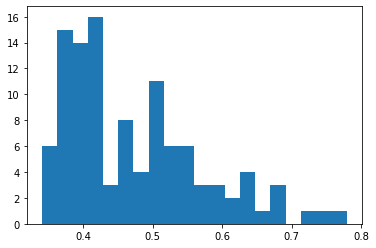

In [8]:
from matplotlib import pyplot as plt

X = list(scores.values())

plt.hist(X, 20)

_min, _max = min(X), max(X)
arg_min, arg_max = list(corpus)[X.index(_min)], list(corpus)[X.index(_max)]

print("Min: {:.2F} ({})".format(_min, arg_min))
print("Max: {:.2F} ({})".format(_max, arg_max))
print("Mean: {:.2F}".format(np.mean(X)))
print("Standard deviation: {:.2F}".format(np.std(X)))
print()
print("{} true sentences (score > .5)".format(sum([x > .5 for x in X])))

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dataset = {sentence: int(score > .5) for sentence, score in scores.items()}

train, test = train_test_split(list(corpus), test_size=1 / 3, random_state=42)

print("Training set:\n{}\n{}".format('\n'.join(train[:3]), '...\n' if len(train) > 3 else ''))
print("Testing set:\n{}\n{}".format('\n'.join(test[:3]), '...\n' if len(test) > 3 else ''))

Training set:
Bob kills Eve
Claire loves Eve
Alice loves Fred
...

Testing set:
Eve loves Fred
Alice kills Eve
Alice loves Eve
...



In [14]:
def loss(corpus, params, mode='boson'):
    return mean_squared_error(*zip(*[
        (dataset[sentence], evaluate(params, sentence, mode=mode))
        for sentence in corpus]))

# testing_loss = lambda params: loss(test, params)
# training_loss = lambda params: loss(train, params)
testing_loss_coherent = lambda params: loss(test, params, mode='coherent')
training_loss_coherent = lambda params: loss(train, params, mode='coherent')
# testing_loss = lambda params: loss(test, params)
# training_loss = lambda params: loss(train, params)
# testing_loss = lambda params: loss(test, params)
# training_loss = lambda params: loss(train, params)

params = random_params().flatten()

print("Random initialisation, training_loss: {:.3f}, testing loss: {:.3f}".format(
    training_loss(params), testing_loss(params)))
print(params)
print()
print("Does Alice love Bob?")
print("Yes" if evaluate(params, 'Alice loves Bob') > .5 else "No")

from noisyopt import minimizeSPSA
from time import time 

Random initialisation, training_loss: 0.247, testing loss: 0.258
[0.24627575 0.81157219 0.33384454 ... 0.88945692 0.50115075 0.43667167]

Does Alice love Bob?
No


In [15]:
training_losses_coherent, testing_losses_coherent = [], []
start = time()
def callback(params):
    training_losses_coherent.append(training_loss_coherent(params))
    testing_losses_coherent.append(testing_loss_coherent(params))
    if not len(training_losses_coherent) % (n_iter // 10) or len(training_losses_coherent) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses_coherent), training_losses_coherent[-1], testing_losses_coherent[-1]))
        print(params)
        print()

params_coherent = params.co
result = minimizeSPSA(training_loss_coherent, params, paired=False, callback=callback, niter=n_iter, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

Iteration 1, training_loss: 0.482, testing loss: 0.470
[0.3018957  0.86719214 0.38946449 ... 0.94507687 0.4455308  0.49229162]

Iteration 2, training_loss: 0.493, testing loss: 0.494
[0.204118   0.96496983 0.48724218 ... 1.04285457 0.54330849 0.39451393]

Iteration 3, training_loss: 0.500, testing loss: 0.499
[0.17152692 0.93237876 0.51983326 ... 1.07544564 0.57589957 0.36192285]

Iteration 4, training_loss: 0.501, testing loss: 0.495
[0.18488228 0.94573411 0.53318861 ... 1.088801   0.58925492 0.3485675 ]

Iteration 5, training_loss: 0.503, testing loss: 0.513
[0.16290128 0.96771511 0.55516961 ... 1.06682    0.56727392 0.3705485 ]

Iteration 6, training_loss: 0.520, testing loss: 0.502
[0.12041625 1.01020013 0.59765464 ... 1.02433497 0.60975895 0.32806347]

Iteration 7, training_loss: 0.484, testing loss: 0.491
[0.15620667 0.97440972 0.63344506 ... 0.98854455 0.64554937 0.36385389]

Iteration 8, training_loss: 0.483, testing loss: 0.480
[0.13519053 0.99542586 0.61242892 ... 1.00956069 

In [18]:
training_losses, testing_losses = [], []
start = time()
def callback(params):
    training_losses.append(training_loss(params))
    testing_losses.append(testing_loss(params))
    if not len(training_losses) % (n_iter // 10) or len(training_losses) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses), training_losses[-1], testing_losses[-1]))
        print(params)
        print()

result = minimizeSPSA(training_loss, params, paired=False, callback=callback, niter=n_iter, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

Iteration 1, training_loss: 0.304, testing loss: 0.283
[0.16889176 0.88043658 0.44836134 ... 0.95442713 0.51981921 0.46784791]

Iteration 2, training_loss: 0.298, testing loss: 0.243
[0.23296221 0.81636613 0.51243178 ... 1.01849758 0.58388965 0.53191836]

Iteration 3, training_loss: 0.297, testing loss: 0.243
[0.22871795 0.82061039 0.51667604 ... 1.02274183 0.58813391 0.53616261]

Iteration 4, training_loss: 0.285, testing loss: 0.245
[0.26478443 0.78454391 0.48060956 ... 1.05880831 0.55206743 0.57222909]

Iteration 5, training_loss: 0.284, testing loss: 0.241
[0.27586622 0.77346212 0.49169135 ... 1.0698901  0.56314922 0.5611473 ]

Iteration 6, training_loss: 0.278, testing loss: 0.238
[0.25441261 0.79491573 0.47023774 ... 1.09134371 0.58460283 0.58260091]

Iteration 7, training_loss: 0.278, testing loss: 0.239
[0.25640125 0.79690437 0.47222638 ... 1.09333235 0.58659147 0.58061227]

Iteration 8, training_loss: 0.277, testing loss: 0.239
[0.25745081 0.79795393 0.47327594 ... 1.09438192 

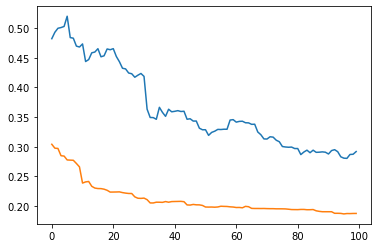

In [19]:
plt.plot(training_losses_coherent)
plt.plot(training_losses)
# plt.plot(testing_losses_coherent)

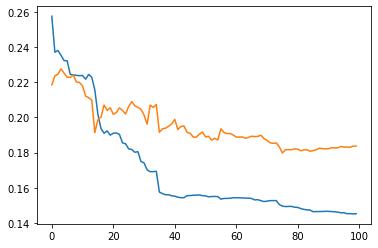

In [15]:
plt.plot(training_losses)
plt.plot(testing_losses)

In [16]:
from sklearn.metrics import classification_report

y_train_true = [dataset[sentence] for sentence in train]
y_train_pred = [evaluate(result.x, sentence) > .5 for sentence in train]

print(classification_report(y_train_true, y_train_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        48
           1       0.95      0.75      0.84        24

    accuracy                           0.90        72
   macro avg       0.92      0.86      0.88        72
weighted avg       0.91      0.90      0.90        72



In [17]:
y_test_true = [dataset[sentence] for sentence in test]
y_test_pred = [evaluate(result.x, sentence) > .5 for sentence in test]

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.65      0.79      0.71        14

    accuracy                           0.75        36
   macro avg       0.74      0.76      0.75        36
weighted avg       0.77      0.75      0.75        36



In [18]:
y_true = y_train_true + y_test_true
y_pred = y_train_pred + y_test_pred

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        70
           1       0.81      0.76      0.78        38

    accuracy                           0.85       108
   macro avg       0.84      0.83      0.84       108
weighted avg       0.85      0.85      0.85       108

